# Converting the Fashion MNIST dataset into a TFRecords object

In this notebook we build a simple TFRecords object from (almost) scratch. Our starting point is the Fashion MNIST dataset in Numpy form as available in Keras.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from keras.datasets import fashion_mnist
%matplotlib inline

tf.reset_default_graph()

Using TensorFlow backend.


We load the numpy arrays representing the images and the lables from Keras.

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(x_train.shape[0], x_test.shape[0])

60000 10000


The images are already stored as Numpy 28 x 28 arrays with dtype uint8.

In [3]:
print(x_train[0].shape)
print(type(x_train))
print(x_train.dtype)

(28, 28)
<class 'numpy.ndarray'>
uint8


## Adding a validation set

We create three data splits, for the training, validation and test sets. For both the validation and the test sets we consider 10000 images.

In [4]:
x_val, y_val = x_train[-10000:], y_train[-10000:]
x_train, y_train = x_train[:-10000], y_train[:-10000]
print(x_train.shape, x_val.shape)

data_splits = {'train': (x_train, y_train), 'val': (x_val, y_val), 'test': (x_test, y_test)}

(50000, 28, 28) (10000, 28, 28)


### Generation of the TFRecords

In [5]:
for data_split in data_splits.keys():
    x, y = data_splits[data_split]
    output_file = os.path.join('../data/fashion_mnist', data_split + '.tfrecords')
    writer = tf.python_io.TFRecordWriter(output_file)
    for index in range(x.shape[0]):
        image = x[index]
        image_raw = image.tostring()
        example = tf.train.Example(
            features=tf.train.Features(
                feature={                    
                    'height': tf.train.Feature(int64_list=tf.train.Int64List(
                        value=[image.shape[0]])),
                    'width': tf.train.Feature(int64_list=tf.train.Int64List(
                        value=[image.shape[1]])),
                    'label': tf.train.Feature(int64_list=tf.train.Int64List(
                        value=[y[index]])),
                    'image_raw': tf.train.Feature(bytes_list=tf.train.BytesList(
                        value=[image_raw]))   
                }))
        writer.write(example.SerializeToString())
    writer.close()

The commands above have created three TFRecords objects, one for each data split.

In [6]:
%ls -lh ../data/fashion_mnist

total 123264
-rw-r--r--  1 gdario  staff   8.3M Mar 19 21:05 test.tfrecords
-rw-r--r--  1 gdario  staff    42M Mar 19 21:04 train.tfrecords
-rw-r--r--  1 gdario  staff   8.3M Mar 19 21:05 val.tfrecords


### TFRecord iterators

To read back the images and the labels from these serialized strings, we can use different approaches. The first one is to use TFRecord iterators defined in `tf.python_io.tf_record_iterator`.

In [7]:
record_iterator = tf.python_io.tf_record_iterator('../data/fashion_mnist/val.tfrecords')
serialized_img = next(record_iterator)

The reconstruct the original image we need to create an instance of the `Example` class, and convert the serialized string into a numpy array. **Note** that `fromstring` is now deprecated in favor of `frombuffer`.

In [8]:
example = tf.train.Example()
example.ParseFromString(serialized_img)

image = example.features.feature['image_raw'].bytes_list.value
label = example.features.feature['label'].int64_list.value[0]
height = example.features.feature['height'].int64_list.value[0]
width = example.features.feature['width'].int64_list.value[0]

img_flat = np.frombuffer(image[0], dtype=np.uint8)
img_reshaped = img_flat.reshape((height, width))

(28, 28)
9


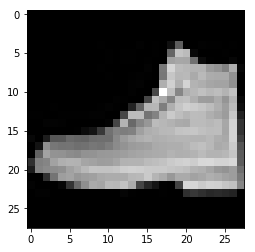

In [9]:
print(img_reshaped.shape)
plt.imshow(img_reshaped, cmap='gray')
print(label)

## Using the Data API

In this section we examine the `tf.data.Dataset` API. The pipeline is supposed to be flexible, allowing to pull images from different TFRecords, applying random transformations to them, and collecting the transformed images into batches.
In our case, we want to create `Dataset`s starting from TFRecords. We will use the `TFRecordDataset` class for this. Let's start creating a dataset for the training set and one for the validation set.

In [10]:
tf.reset_default_graph()

training_set = tf.data.TFRecordDataset('../data/fashion_mnist/train.tfrecords')
validation_set = tf.data.TFRecordDataset('../data/fashion_mnist/val.tfrecords')

Unce we have a dataset, we can iterate on it with a dataset iterator. There are several types of iterators, the simplest of which is the *one-shot iterator*. In the example below we extract the first element from the validation set.

In [11]:
one_shot_iterator = validation_set.make_one_shot_iterator()
next_element = one_shot_iterator.get_next()
next_element

<tf.Tensor 'IteratorGetNext:0' shape=() dtype=string>

As we can see, the element contained in `next_element` is a tensor of dtype `string`. To visualize the string, we need to evaluate the tensor in a session.

In [12]:
with tf.Session() as sess:
    tmp = sess.run(next_element)
    print(tmp)

b'\n\xd8\x06\n\x0f\n\x06height\x12\x05\x1a\x03\n\x01\x1c\n\x0e\n\x05label\x12\x05\x1a\x03\n\x01\t\n\xa4\x06\n\timage_raw\x12\x96\x06\n\x93\x06\n\x90\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x02\x00\x01\x00\x10^\x00\x00\x02\x01\x01\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x01\x01\x00\x00\x01\x00e\xc4\xbb\x08\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x01\x01\x00\x01\x00\x00\xa1\xa7\xa6p\x0b\x01\x00\x00\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x03\x00y\xd5

We need two things:
1. A mechanism to handle the training set and the validation set differently.
2. A way of introducing transformations into the serialized objects.

For the former we can rely on either *(re)initializable* iterators or *feedable iterators*. These are illustrated in the [importing data](https://www.tensorflow.org/programmers_guide/datasets) guide. Let's consider an example with an initiable iterator. We create a placeholder that will store the string with the full path to the TFRecords object. We then create a node that create a TFRecord dataset using the information stored in this placeholder. Finally we create an initializable iterator that is initialized by the content of the placeholder.

In [13]:
filenames = tf.placeholder(dtype=tf.string, shape=None)
dataset = tf.data.TFRecordDataset(filenames)
iterator = dataset.make_initializable_iterator()

with tf.Session() as sess:
    sess.run(iterator.initializer, 
             feed_dict={filenames: '../data/fashion_mnist/val.tfrecords'})
    next_train_example = sess.run(iterator.get_next())
    print(type(next_train_example))
    sess.run(iterator.initializer, 
             feed_dict={filenames: '../data/fashion_mnist/train.tfrecords'})
    next_val_example = sess.run(iterator.get_next())
    print(len(next_val_example))

<class 'bytes'>
859


## Applying transformations to the elements of a dataset

Our datasets contained the serialized string representation of the images and of their labels. We want to extract this information. Typical pipelines extract **tf.train.Example** protocol buffer *messages*. Each of these messages contains one or more *features*, and we typically want to convert these messages into tensors.

Let's write a function that reads the protocol buffers messages from a TFRecordDataset and returns tensors. There are a few things to note:

1. The input of `image_raw` are Numpy arrays, not images, therefore we use `tf.decode_raw`, not `tf.decode_image`.
2. We need to convert `height` and `weight` into `tf.int32`, otherwise the reshaping operation fails.
3. We reshape the labels (**TODO**: should have we done it beforehand?)

In [18]:
def convert_serialized_example_to_tensor(serialized_example):
    """Convert a serialized example into a normalized image."""
    features = {'image_raw': tf.FixedLenFeature((), tf.string, default_value=''),
                'label': tf.FixedLenFeature((), tf.int64, default_value=0),
                'height': tf.FixedLenFeature((), tf.int64, default_value=28),
                'width': tf.FixedLenFeature((), tf.int64, default_value=28)}
    parsed_features = tf.parse_single_example(serialized_example, features)
    
    label = tf.reshape(parsed_features['label'], [1]) # label is a tf.int64
    
    # Convert height and weight from tf.int64 to tf.int32
    height, width = parsed_features['height'], parsed_features['width']
    height, width = tf.cast(height, tf.int32), tf.cast(width, tf.int32)
    
    # Cast the decoded image into tf.uint8 and then into tf.float32
    image = tf.cast(tf.decode_raw(parsed_features['image_raw'], tf.uint8), tf.float32)
    image = tf.reshape(image / 255., [height, width])
    return image, label

In [19]:
dataset = training_set.map(convert_serialized_example_to_tensor)

iterator = dataset.make_one_shot_iterator()
next_element = iterator.get_next()
with tf.Session() as sess:
    img, lbl = sess.run(next_element)
    print(img.shape, img.dtype, lbl.shape, lbl.dtype)

(28, 28) float32 (1,) int64


## Batching

Once we have a deserialized dataset, generating batches is very simple, as it just require the use of the `batch` method.

In [20]:
batched_dataset = dataset.batch(32)
iterator = batched_dataset.make_one_shot_iterator()
next_batch = iterator.get_next()

with tf.Session() as sess:
    image_batch, label_batch = sess.run(next_batch)
    print(image_batch.shape, label_batch.shape)

(32, 28, 28) (32, 1)
